In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

#import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from numpy import array

import tensorflow as tf


In [4]:
import h5py

f1 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_IMRPhenomXPHM_signal_noise_SNR-8to40_mchirp_all.hdf","r")


In [5]:
strain_1 = f1['injection_samples']['l1_strain'][0:25][()]
               
signal_1 = f1['injection_parameters']['l1_signal_whitened'][0:25][()]

strain = strain_1
signal = signal_1


In [6]:
noise_strain_1 = f1['noise_samples']['l1_strain'][0:25][()]
noise_signal_1 = f1['noise_parameters']['l1_signal'][0:25][()]

noise_strain = noise_strain_1
noise_signal = noise_signal_1

# Concatenate the arrays
concatenated_array_signal = np.concatenate((signal, noise_signal))

# Concatenate the arrays
concatenated_array_strain = np.concatenate((strain, noise_strain))
    
strain = concatenated_array_strain
signal = concatenated_array_signal
            

In [10]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
#            dataset[dataset==0.0] = 1e-6
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
        for j in range(samples):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array


In [11]:
strain = _preprocess_data(strain, 25, 2048)
signal = _preprocess_data(signal, 25, 2048)
        
X_test_noisy = strain
X_test_pure = signal


In [13]:
X_test_noisy = np.array(X_test_noisy)

X_test_pure = np.array(X_test_pure)
        

X_test_noisy = X_test_noisy[:,:,None]

X_test_pure = X_test_pure[:,:,None]
        

print('x_test_noisy shape:', X_test_noisy.shape)

print('x_test_pure shape:', X_test_pure.shape)


X_test_noisy = X_test_noisy.astype("float32")

X_test_pure = X_test_pure.astype("float32")


x_test_noisy shape: (25, 2048, 1)
x_test_pure shape: (25, 2048, 1)


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
def denoising_autoencoder(input_shape=(2048, 1), d_model=64, ff_dim=64, num_heads=4, num_transformer_blocks=4):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv1D(filters=d_model, kernel_size=1, activation="relu")(x)

    for _ in range(num_transformer_blocks):
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model, dropout=0.3
        )(x, x)
        x = layers.Dropout(0.3)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        x_ff = models.Sequential([
            layers.Conv1D(ff_dim, kernel_size=1, activation="relu"),
            layers.Dropout(0.3),
            layers.Conv1D(d_model, kernel_size=1),
            ]
        )(x)

        x = layers.Add()([x, x_ff])

    # Decoder
    x = layers.Conv1DTranspose(filters=1, kernel_size=1, activation="linear")(x)

    # Create the model
    model = tf.keras.Model(inputs, x, name="denoising_autoencoder")
    return model

# Instantiate the model
autoencoder = denoising_autoencoder()

# Compile the model
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Display the model summary
autoencoder.summary()


Model: "denoising_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 1)]    0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 1)     4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 64)     128         ['batch_normalization[0][0]']    
                                                                                                  
 multi_head_attention (MultiHea  (None, 2048, 64)    66368       ['conv1d[0][0

In [1]:
import h5py
import numpy as np

from matplotlib import pyplot as plt

f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMRPhenomXPHM_O3b_signal_noise_SNR-8to30_mchirp_all_BNN.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/default_IMBH_test_IMRPhenomXPHM_signal_noise_SNR-20to40_mchirp_all.hdf", 'r')


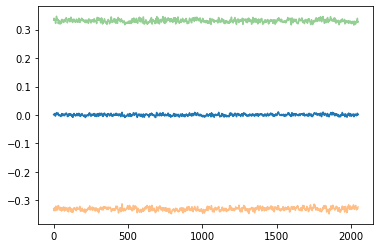

In [5]:
#plt.plot(f2['injection_samples']['l1_strain'][2], alpha=0.5)
#plt.plot(f2['injection_parameters']['l1_signal_whitened'][2], alpha=0.5)
plt.plot(f1['mean_signals'][0][0])
plt.plot(f1['m2sd_signals'][0][0], alpha=0.5)
plt.plot(f1['p2sd_signals'][0][0], alpha=0.5)


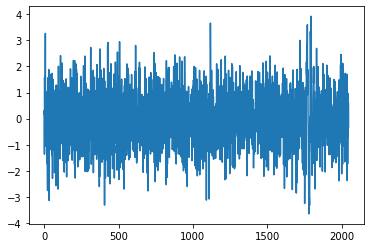

In [3]:
plt.plot(f2['injection_samples']['l1_strain'][0])


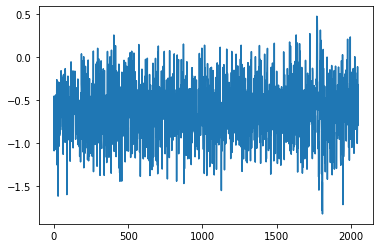

In [15]:
plt.plot(f1['m2sd_signals'][0][0][0])


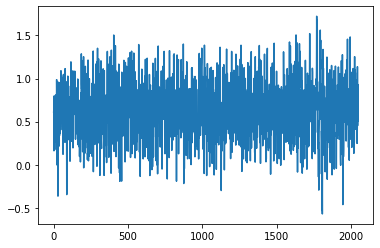

In [16]:
plt.plot(f1['p2sd_signals'][0][0][0])


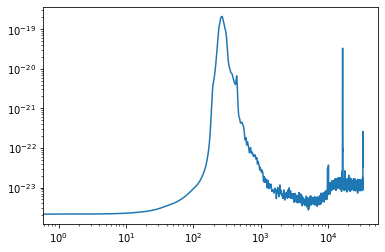

In [8]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/real_events_GW190503_185404_test.hdf', 'r')

plt.plot(np.sqrt(f1['GW190503_185404-v1']['l1_psd'][()]))
plt.xscale('log')
plt.yscale('log')


In [23]:
import h5py
import numpy as np

from matplotlib import pyplot as plt

f1 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_train_IMRPhenomXPHM_SNR-20to40_mchirp_all_whitening_fixed.hdf', 'r')

f2 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-20to40_mchirp_all_whitening_fixed.hdf', 'r')



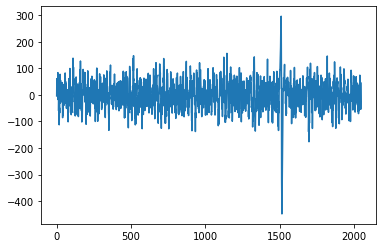

In [32]:
plt.plot(f2['injection_samples']['l1_strain'][0])


In [4]:
import h5py

f1 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_IMRPhenomXPHM_signal_noise_SNR-8to30.hdf','r')

f1['injection_samples']['l1_strain'][()].shape


(25, 2048)

In [ ]:
import tensorflow as tf

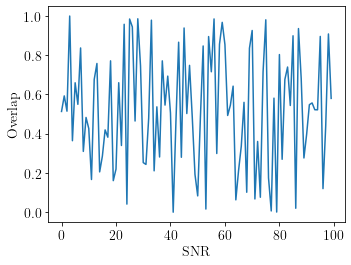

In [4]:
from matplotlib import pyplot as plt
import matplotlib_latex_bridge as mlb
import numpy as np

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

#fig = mlb.figure_textwidth()  # for full page images
fig = mlb.figure_columnwidth()  # for full column images

# Increase the font size of the numbers on the axes
plt.xticks(fontsize=14)  # Increase fontsize for x-axis tick labels
plt.yticks(fontsize=14)  # Increase fontsize for y-axis tick labels

a = np.random.random(100)

plt.plot(a)

plt.ylabel('Overlap', fontsize=14)
plt.xlabel('SNR', fontsize=14)

fig.savefig('Test.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)

In [40]:
import h5py

f1 = h5py.File('/workspace/ligo_data/ml-training-strategies/data/train_signals.hdf', 'r')
f2 = h5py.File('/workspace/ligo_data/ml-training-strategies/data/train_noise.hdf', 'r')


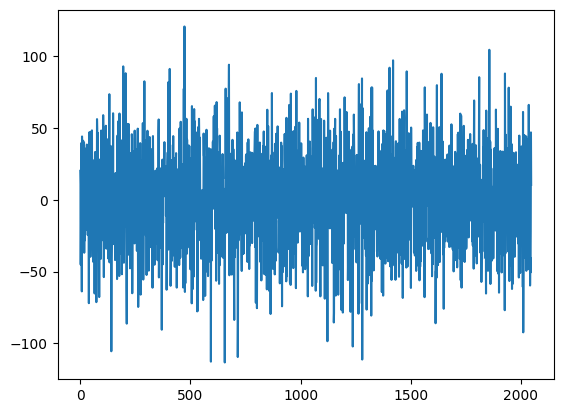

In [43]:
from matplotlib import pyplot as plt

plt.plot(f2['data']['0'][0])

In [86]:
from numpy import random

strain = []
snr_array = []
for i in range(100):

    snr = random.default_rng().uniform(low=5, high=15)
    strain.append(f2['data']['0'][i].squeeze() + (snr*f1['data']['0'][i]).squeeze())
    snr_array.append(snr)


In [87]:
import numpy as np

strain = np.array(strain)

In [88]:
strain.shape

(100, 2048)

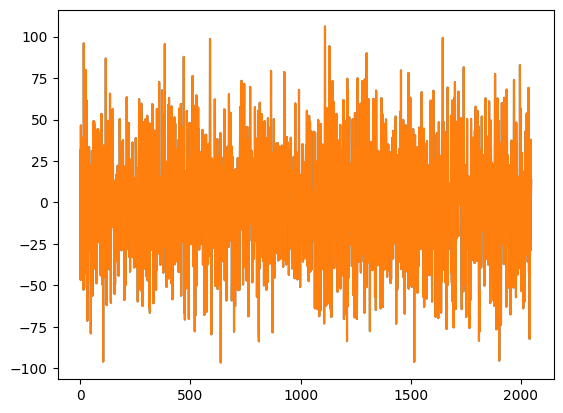

In [89]:
plt.plot(strain[0]-(snr_array[0]*f1['data']['0'][0]).squeeze())
plt.plot(f2['data']['0'][0])